This notebook is a replica of *Notebook 2--Inverse-design*, except that it modifies the `TDwgNet` function to have a mismatched forward- and backward pass to emulate the imperfections of real experiments. Any design notebooks in this repository using inverse-desing can be modified to do the same by replacing the `TDwgNet` function with the one presented in this notebook.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import tdwg_lib.ftutils_torch as ftutils
from tdwg_lib.split_step_solver import BPMSplitStepSolver
from tdwg_lib.waveguide import Waveguide, add_absorbing_boundary
from tdwg_lib.beam_utils import gaussian_beam, make_HG_modes
from tdwg_lib.helpers import smoothen2d, timestring
from tdwg_lib.pat import make_pat_func
from tdwg_lib.pnn_utils import L2, has_converged
from tdwg_lib import pnn_utils 

## Parameters

In [3]:
NMODES = 2  # Number of input/output modes

# Waveguide parameters
LAMBDA0 = 1.55  # Free-space wavelength in μm
K0 = 2*np.pi/LAMBDA0  # Free-space wavenumber in μm⁻¹
NEFF = 1.8  # Effective refractive index of slab mode

# Transverse (x) axis
LX = 500  # Width of simulation area in μm
NX = 2**9  # Number of grid points in transverse dimension
DX = LX/(NX-1)  # Grid spacing in transverse dimension in μm
X_AXIS = ftutils.ft_t_axis(NX, DX)  # Centered frequency-domain axis

# Propagation (z) axis
DZ = 50  # Propagation step size in μm
LZ = 10000  # Total propagation length in μm
NZ = int(np.floor(LZ/DZ))  # Number of propagation steps
Z_AXIS = (torch.arange(NZ)+1)*DZ  # Propagation coordinate starting at DZ

# Mode properties
MODE_X_MIN = -50 * (NMODES-1)  # Center position of leftmost input mode in μm
MODE_X_MAX = 50 * (NMODES-1)  # Center position of rightmost input mode in μm
W0 = 20  # Beam waist (1/e² radius) in μm

# Training parameters
DELTA_N_VAL = 1e-3  # Maximum refractive index change
ITERATIONS = 150  # Number of training epochs
LR = 0.03 # Learning rate for optimizer
GAMMA = 0.99  # Learning rate decay factor
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Waveguide container object stores simulation geometry and parameters
background_delta_n = torch.zeros(NX, dtype=torch.complex64)
background_delta_n = add_absorbing_boundary(X_AXIS, background_delta_n, K0)  # Add PML boundaries
wg = Waveguide(NEFF, X_AXIS, Z_AXIS, background_delta_n, device=DEVICE)

## Create trainable 2D waveguide class as pytorch.nn.Module 

### New here: Separate forward- and backward-pass functions

The `TDwgNet` class has separate `forward_internal` and `backward_internal` functions, which are fused into a single function `f_pat`, which calls the correct function on the forward/backward pass. 

The `forward_internal` function could be replaced with code that calls an experiment instead.
To emulate the imperfections of real experimental setups, we have added an artificial misalignment of the inputs in the `forward_internal` function.

In [4]:
class TDwgNet(nn.Module):
    def __init__(self, solver, wg, delta_n_val, inds_misalignment, device, mode='insilico', res_x=6, res_z=6):
        super(TDwgNet, self).__init__()
        self.device = device
        
        # Initialize trainable modulation parameter with bounds [0.05, 0.95]
        mod = 0.5*torch.ones([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[0.05, 0.95])
        
        self.delta_n_val = delta_n_val  # Maximum refractive index change
        self.scale_x = res_x  # Resolution limit in x-direction (smoothing scale)
        self.scale_z = res_z  # Resolution limit in z-direction (smoothing scale)
        self.inds_misalignment = inds_misalignment # number of indices by which inputs will be misaligned
        
        self.wg = wg
        self.solver = solver
        
        # Set up physics-aware training (PAT) if mode='pat', otherwise use standard forward
        if mode == 'pat': 
            self.f_pat = make_pat_func(self.forward_internal, self.backward_internal)
        if mode == 'insilico': 
            self.f_pat = self.forward_internal

    def forward(self, input_fields):
        # Main forward pass: calls either PAT or standard forward
        output_fields = self.f_pat(input_fields, self.mod)
        return output_fields

    def forward_internal(self, input_fields, mod, monitor=False):
        """Forward pass with experimental imperfections (e.g., misaligned inputs)."""
        # Clip modulation to valid range and apply smoothing filter to emulate finite resolution
        delta_n_prog = self.delta_n_val*mod.clip(0., 1.)
        delta_n_prog = smoothen2d(self.wg.x_axis, self.wg.z_axis, delta_n_prog, scale_x=self.scale_x, scale_z=self.scale_z)

        # Apply artificial misalignment to input fields to emulate experimental imperfections
        inputs_misaligned = torch.roll(input_fields.to(self.device), self.inds_misalignment, dims=-1)
        
        # Compute refractive index distribution (could add unmodeled inhomogeneities here)
        delta_n = self.wg.background_delta_n + delta_n_prog
        
        # Propagate through waveguide and return output fields
        output_fields = self.solver.run_simulation(inputs_misaligned, delta_n, monitor)
        return output_fields
        
    def backward_internal(self, input_fields, mod):
        """Backward pass with ideal (non-misaligned) inputs for gradient calculation."""
        # Clip modulation to valid range and apply smoothing filter to emulate finite resolution
        delta_n_prog = self.delta_n_val*mod.clip(0., 1.)
        delta_n_prog = smoothen2d(self.wg.x_axis, self.wg.z_axis, delta_n_prog, scale_x=self.scale_x, scale_z=self.scale_z)

        # Use ideal (non-misaligned) input fields for gradient calculation
        inputs = input_fields.to(self.device)
        
        # Compute refractive index distribution
        delta_n = self.wg.background_delta_n + delta_n_prog
        
        # Propagate through waveguide and return output fields
        output_fields = self.solver.run_simulation(inputs, delta_n)
        return output_fields

# Define input and output modes

In [5]:
INPUT_MISALIGNMENT = 15  # Transverse misalignment of inputs in μm
# Play around with this value to see whether the training algorithm can handle the misalignment
# A misalignment of 50 μm does not work well anymore

In [6]:
# Input modes: Gaussian beams evenly spaced from MODE_X_MIN to MODE_X_MAX
INPUT_MODES = torch.vstack([gaussian_beam(X_AXIS, mu, W0) for mu in np.linspace(MODE_X_MIN, MODE_X_MAX, NMODES)])

# Target output modes: Hermite-Gauss modes centered at x=0
TARGET_OUTPUT_MODES = make_HG_modes(X_AXIS, x_center=0, w0=W0, n=NMODES)

In [7]:
# Calculate misalignment in grid indices
INDS_MISALIGNMENT = wg.x2ind(INPUT_MISALIGNMENT) - wg.x2ind(0)

# Create misaligned input modes for visualization
input_modes_misaligned = torch.roll(INPUT_MODES, INDS_MISALIGNMENT, dims=-1)

C:\Users\MartinStein\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\MartinStein\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:5620: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
C:\Users\MartinStein\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


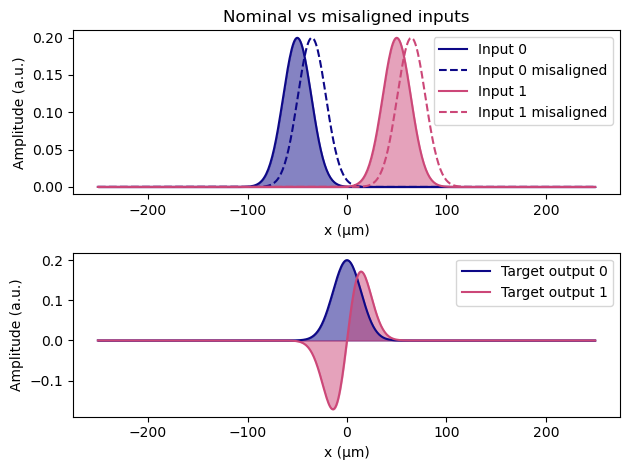

In [8]:
# Plot nominal vs misaligned input modes
plt.subplot(2, 1, 1)
for ind_mode, mode in enumerate(INPUT_MODES):
    plt.plot(X_AXIS, mode.real.cpu(), color=cm.plasma(ind_mode/NMODES), label=f"Input {ind_mode}")
    plt.fill_between(X_AXIS, mode, color=cm.plasma(ind_mode/NMODES), alpha=0.5)
    plt.plot(X_AXIS, input_modes_misaligned[ind_mode].real.cpu(), color=cm.plasma(ind_mode/NMODES), ls='--', label=f"Input {ind_mode} misaligned")

plt.legend(loc='upper right')
plt.xlabel('x (μm)')
plt.title('Nominal vs misaligned inputs')
plt.ylabel('Amplitude (a.u.)')

# Plot target output modes
plt.subplot(2, 1, 2)
for ind_mode, mode in enumerate(TARGET_OUTPUT_MODES):
    plt.fill_between(X_AXIS, mode.real, color=cm.plasma(ind_mode/NMODES), alpha=0.5)
    plt.plot(X_AXIS, mode.real, color=cm.plasma(ind_mode/NMODES), label=f'Target output {ind_mode}')

plt.legend(loc='upper right')
plt.xlabel('x (μm)')
plt.ylabel('Amplitude (a.u.)')

plt.tight_layout()

## Training loop

In [9]:
# Initialize beam propagation method solver
bpmsolver = BPMSplitStepSolver(X_AXIS, Z_AXIS, NEFF)

# Create 2D-waveguide object with trainable index modulation (mode='pat' enables physics-aware training)
tdwg_pnn = TDwgNet(bpmsolver, wg, DELTA_N_VAL, INDS_MISALIGNMENT, DEVICE, mode='pat')

# Setup Adam optimizer
optimizer = optim.Adam(tdwg_pnn.parameters(), lr=LR)

# Setup learning rate scheduler with exponential decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

# Set model to training mode
tdwg_pnn.train()

TDwgNet()

In [10]:
PRINT_INTERVAL = 10  # Print loss every N iterations

loss_list = []

for i in range(ITERATIONS):
    optimizer.zero_grad()  # Reset gradients

    # Forward pass: propagate all input modes through waveguide
    output_fields = tdwg_pnn.forward(INPUT_MODES.to(DEVICE))
    
    # Objective loss: L2 distance between output fields and target output modes
    l_objective = L2(TARGET_OUTPUT_MODES.to(DEVICE), output_fields)

    # Lagrangian penalty: enforce parameter bounds (limiting largest refractive index change)
    l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp=1, factor=20)
    
    # Total loss
    l = l_objective + l_lagrange
    l.backward()  # Compute gradients
        
    optimizer.step()  # Update parameters
    scheduler.step()  # Decay learning rate
    loss_list.append(l.detach().cpu().data)

    # Print progress
    if i % PRINT_INTERVAL == 0:
        print(timestring() + f"--Iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
    # Early stopping commented out for demonstration
    if has_converged(loss_list, std_threshold=1e-3):
        print(timestring() + f"Converged at iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
        break

C:\Users\MartinStein\OneDrive - Yale University\Work\Github\2D-waveguide-demo-code\tdwg_lib\split_step_solver.py:184: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dz = torch.tensor(self.dz, device=device, dtype=delta_n.dtype)


2025-10-04--18-05-50--Iteration: 0, Loss: 0.83147
2025-10-04--18-05-54--Iteration: 10, Loss: 0.40602
2025-10-04--18-05-58--Iteration: 20, Loss: 0.23568
2025-10-04--18-06-01--Iteration: 30, Loss: 0.13784
2025-10-04--18-06-05--Iteration: 40, Loss: 0.09612
2025-10-04--18-06-09--Iteration: 50, Loss: 0.07280
2025-10-04--18-06-13--Iteration: 60, Loss: 0.06028
2025-10-04--18-06-17--Iteration: 70, Loss: 0.05256
2025-10-04--18-06-21--Iteration: 80, Loss: 0.04843
2025-10-04--18-06-25--Iteration: 90, Loss: 0.04238
2025-10-04--18-06-29--Iteration: 100, Loss: 0.03881
2025-10-04--18-06-33--Iteration: 110, Loss: 0.03624
2025-10-04--18-06-37--Iteration: 120, Loss: 0.03376
2025-10-04--18-06-41--Iteration: 130, Loss: 0.03176
2025-10-04--18-06-44--Iteration: 140, Loss: 0.03020


Text(0, 0.5, 'Loss')

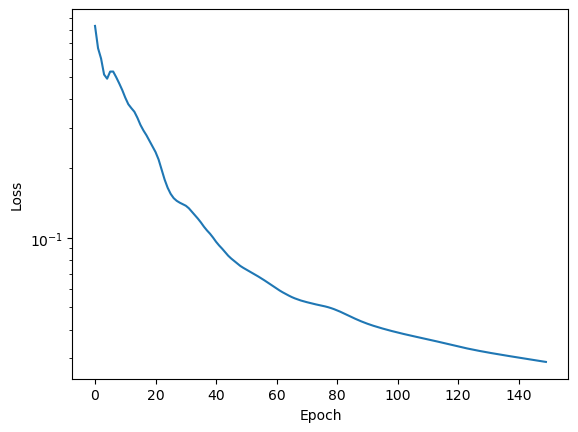

In [11]:
# Plot training loss history
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [12]:
# Perform forward pass with monitor=True to store internal optical fields for visualization
with torch.no_grad():
    output_fields = tdwg_pnn.forward_internal(INPUT_MODES.to(DEVICE), tdwg_pnn.mod, monitor=True)

# Compute relative error: mean absolute difference normalized by target magnitude
avg_error_inv = torch.mean(torch.abs(output_fields - TARGET_OUTPUT_MODES.to(DEVICE))) / torch.mean(torch.abs(TARGET_OUTPUT_MODES.to(DEVICE))) * 100
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

Average error for inverse design: 15.68%


## Plot results

In [13]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot refractive index: convert z to mm, take real part, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="Greens", vmax=vmax, vmin=0)
    
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(r"$\Delta n(x, z)$")
    plt.colorbar()

    plt.show()

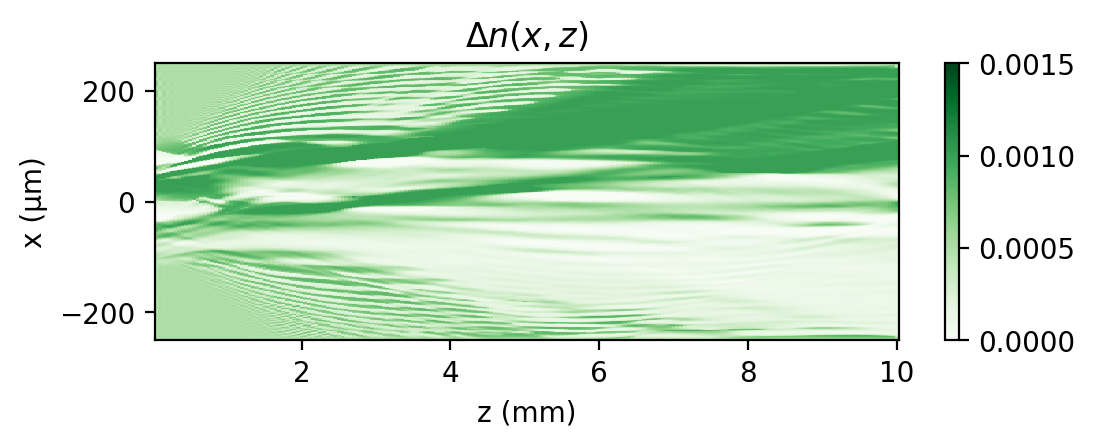

In [14]:
# Extract optimized refractive index: clip and scale trained modulation parameter
delta_n_inv = DELTA_N_VAL * (torch.clip(tdwg_pnn.mod.detach().cpu(), 0., 1.))

# Plot optimized refractive index distribution
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, 1.5*DELTA_N_VAL)

In [15]:
def plot_intensity(z_axis, x_axis, Imat_x):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot intensity: convert z to mm, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, Imat_x, cmap="Reds")
    
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(r"$I(x, z)$")
    plt.colorbar()

    plt.show()

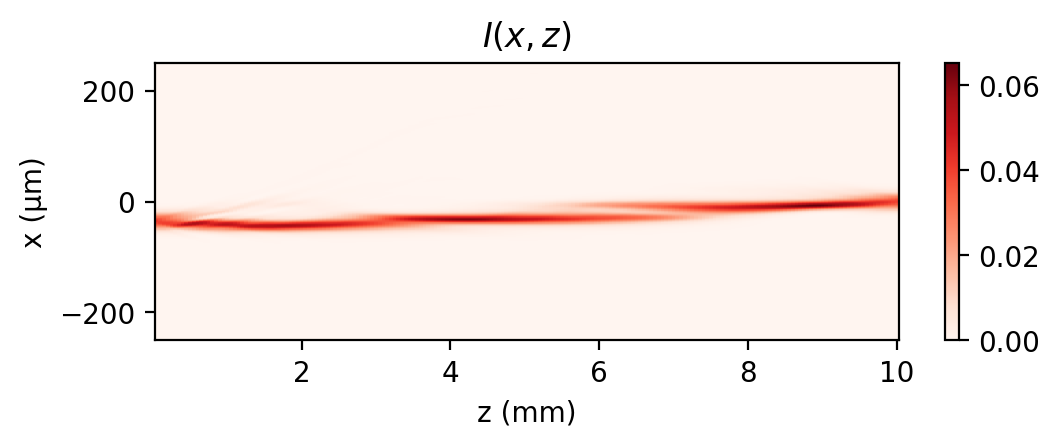

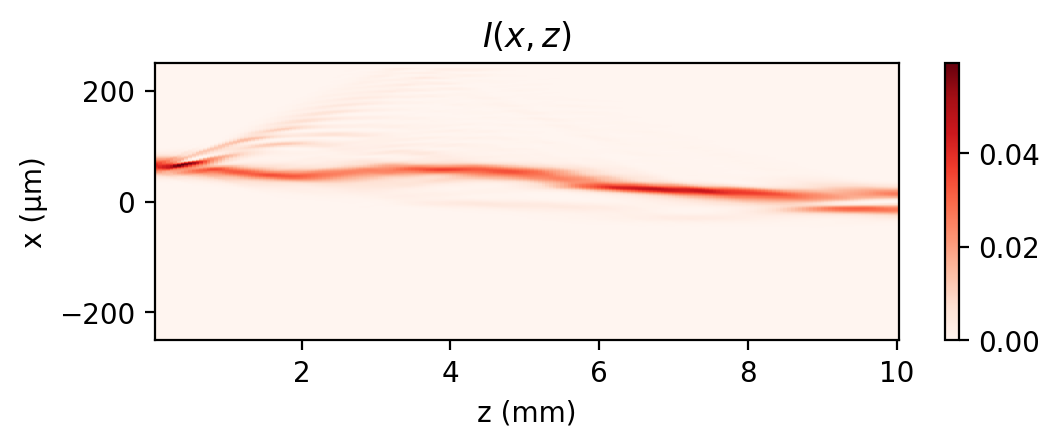

In [16]:
# Plot intensity evolution for mode 0
IND = 0
Emat_x = tdwg_pnn.solver.Emat_x[:, IND].cpu().detach()
Imat_x = Emat_x.abs().square()  # Compute intensity: |E|²
z_list = Z_AXIS[::tdwg_pnn.solver.Ncom]  # Downsample z-axis based on monitor interval
plot_intensity(z_list, X_AXIS, Imat_x.T)

# Plot intensity evolution for mode 1
IND = 1
Emat_x = tdwg_pnn.solver.Emat_x[:, IND].cpu().detach()
Imat_x = Emat_x.abs().square()  # Compute intensity: |E|²
z_list = Z_AXIS[::tdwg_pnn.solver.Ncom]  # Downsample z-axis based on monitor interval
plot_intensity(z_list, X_AXIS, Imat_x.T)

In [17]:
# Extract output field at final propagation step
Eout_x = tdwg_pnn.solver.Emat_x[-1].cpu().detach()

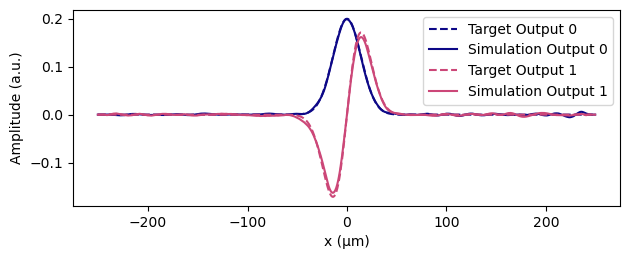

In [18]:
# Compare target output modes with achieved simulation outputs
plt.subplot(2, 1, 2)
for ind_mode, mode in enumerate(TARGET_OUTPUT_MODES):
    # Plot target output modes
    plt.plot(X_AXIS, mode.real, color=cm.plasma(ind_mode/NMODES), ls='--', label=f'Target Output {ind_mode}')
    # Plot achieved simulation outputs
    plt.plot(X_AXIS, Eout_x[ind_mode].real, color=cm.plasma(ind_mode/NMODES), label=f'Simulation Output {ind_mode}')

plt.legend(loc='upper right')
plt.xlabel('x (μm)')
plt.ylabel('Amplitude (a.u.)')

plt.tight_layout()